# Persiapaan Awal

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [3]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [4]:
df = pd.read_csv('sentiment_6000.csv')
df.head(10)

,content,sentimen
0,politikus senior pdi perjuangan panda nababan ...,Negative
1,wali kota depok mohammad idris menanggapi nyin...,Negative
2,ketua tim pemenangan nasional tpn ganjar prano...,Negative
3,aksi arogan sopir fortuner mengacungkan pedang...,Negative
4,7 bocah korban gigitan seekor monyet liar depo...,Negative
5,menteri koordinator bidang pembangunan manusia...,Negative
6,ketua tim hukum nasional amin ari yusuf menyes...,Negative
7,macet jalan tb simatupang arah pasar rebo jaka...,Negative
8,pekerja terjatuh plafon masjid at muttaqien ka...,Negative
9,eks direktur rsud padang sidimpuan sumatera ut...,Negative


In [5]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [6]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [7]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [8]:
# Bag of Words (BoW) features
count_vectorizer, count_train_features = tfidf_extractor(x_train, ngram_range=(1, 1))  # Unigram features
count_test_features = count_vectorizer.transform(x_test)

In [9]:
# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

### World Cloud

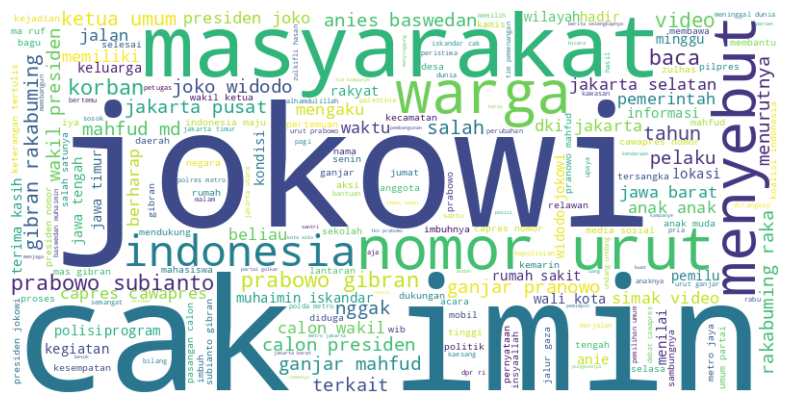

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### LSA

In [11]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define the number of topics
num_topics = 10

# Perform LSA
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_train_features = lsa_model.fit_transform(tfidf_train_features)

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to print the most important words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the most important words for each topic
print("LSA Topics:")
print_top_words(lsa_model, feature_names, 10)

LSA Topics:

Topic #0:
prabowo gibran ganjar jokowi anies presiden indonesia cawapres mahfud debat

Topic #1:
israel korban gaza hamas palestina pelaku serangan warga rumah tewas

Topic #2:
imin cak cak imin anies ganjar amin mahfud muhaimin baswedan anies baswedan

Topic #3:
israel gaza hamas palestina serangan imin cak imin cak jalur gaza anies

Topic #4:
ganjar mahfud ganjar mahfud jokowi pranowo ganjar pranowo mahfud md md pdip presiden

Topic #5:
jokowi pan zulhas partai indonesia presiden pemilu anies joko widodo widodo

Topic #6:
kpk firli bahuri firli bahuri syahrul syl pemerasan metro jaya ketua kpk polda metro

Topic #7:
pan zulhas debat gibran cawapres zulkifli hasan zulkifli hasan debat cawapres firli

Topic #8:
debat jokowi debat cawapres cawapres tni jakarta ikn ekonomi dki heru

Topic #9:
debat korban jokowi pelaku prabowo kpu capres pan cawapres debat cawapres


In [13]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Function to generate word cloud for each topic
# def generate_wordclouds(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
#         wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis("off")
#         plt.title(f"Topic #{topic_idx}")
#         plt.show()

# # Generate word clouds for LSA topics
# generate_wordclouds(lsa_model, feature_names, 10)


## Model Naiye Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

In [13]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    return accuracy, f1

#### Tanpa Parameter

In [14]:
# Initialize Naive Bayes classifier
model_naiye_tanpa_parameter = MultinomialNB()

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 72.5
TF-IDF Vectorization F1 Score: 72.07885925451141
Bag of Words (BoW) Accuracy: 73.61111111111111
Bag of Words (BoW) F1 Score: 73.2670540495773
Combined TF-IDF and BoW Accuracy: 72.5
Combined TF-IDF and BoW F1 Score: 72.04764635085637


#### Pakai Parameter

In [17]:
# Initialize Naive Bayes classifier
model_naiye_parameter = MultinomialNB(alpha= 0.1,fit_prior=False)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_naiye_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_naiye_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_naiye_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 73.66666666666667
TF-IDF Vectorization F1 Score: 73.24275661448925
Bag of Words (BoW) Accuracy: 73.88888888888889
Bag of Words (BoW) F1 Score: 73.49939674435552
Combined TF-IDF and BoW Accuracy: 74.0
Combined TF-IDF and BoW F1 Score: 73.59718028448735


## Model SVM

In [18]:
from sklearn.svm import SVC

#### Tanpa Parameter Sederhana

In [19]:
# Initialize SVM
model_svm_tanpa_parameter =  SVC(kernel='linear', random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 76.94444444444444
TF-IDF Vectorization F1 Score: 76.71137201946466
Bag of Words (BoW) Accuracy: 76.94444444444444
Bag of Words (BoW) F1 Score: 76.8073219376204
Combined TF-IDF and BoW Accuracy: 77.0
Combined TF-IDF and BoW F1 Score: 76.86844020216803


#### Pakai Parameter

In [20]:
# Initialize SVM
model_svm_parameter =  SVC(C=100, gamma=0.1, kernel='sigmoid')

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_svm_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_svm_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_svm_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 77.83333333333333
TF-IDF Vectorization F1 Score: 77.66190159096202
Bag of Words (BoW) Accuracy: 76.77777777777777
Bag of Words (BoW) F1 Score: 76.71743326018313
Combined TF-IDF and BoW Accuracy: 77.16666666666666
Combined TF-IDF and BoW F1 Score: 77.0455979383556


## Model Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression


#### Tanpa Parameter

In [22]:
# Initialize Naive Bayes classifier
model_lr_tanpa_parameter = LogisticRegression(random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 75.83333333333333
TF-IDF Vectorization F1 Score: 75.6071527211668
Bag of Words (BoW) Accuracy: 77.72222222222223
Bag of Words (BoW) F1 Score: 77.62039383708893
Combined TF-IDF and BoW Accuracy: 77.88888888888889
Combined TF-IDF and BoW F1 Score: 77.75255652383589


#### Parameter

In [23]:
# Initialize Naive Bayes classifier
model_lr_parameter = LogisticRegression(C=10,penalty="l2",random_state=42,max_iter=1000)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_lr_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_lr_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 77.5
TF-IDF Vectorization F1 Score: 77.31233596123465
Bag of Words (BoW) Accuracy: 77.66666666666666
Bag of Words (BoW) F1 Score: 77.57621501040457
Combined TF-IDF and BoW Accuracy: 78.22222222222223
Combined TF-IDF and BoW F1 Score: 78.09177796435804


## Model Random Forest 

In [24]:
from sklearn.ensemble import RandomForestClassifier

#### Tanpa Parameter

In [25]:
# Initialize SVM
model_rfc_tanpa_parameter =  RandomForestClassifier(random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_tanpa_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_tanpa_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_tanpa_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 74.6111111111111
TF-IDF Vectorization F1 Score: 74.4339382183648
Bag of Words (BoW) Accuracy: 74.94444444444444
Bag of Words (BoW) F1 Score: 74.80244035349911
Combined TF-IDF and BoW Accuracy: 75.05555555555556
Combined TF-IDF and BoW F1 Score: 74.94382957653092


#### Parameter

In [27]:
# Initialize SVM
model_rfc_parameter =  RandomForestClassifier(min_samples_split=10,min_samples_leaf=2,n_estimators=150, random_state=42)

# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(model_rfc_parameter , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(model_rfc_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(model_rfc_parameter , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 75.66666666666667
TF-IDF Vectorization F1 Score: 75.46531854489675
Bag of Words (BoW) Accuracy: 76.11111111111111
Bag of Words (BoW) F1 Score: 75.9408156632015
Combined TF-IDF and BoW Accuracy: 76.22222222222223
Combined TF-IDF and BoW F1 Score: 76.0687487526783


## Model Ensemble Learning

In [28]:
# Mengambil model terbaik dari hasil tuning
best_model_naive_bayes = model_naiye_parameter
best_model_svm = model_svm_parameter
best_model_random_forest = model_rfc_parameter
best_model_logistic_regression = model_lr_parameter

In [29]:
from sklearn.ensemble import VotingClassifier

#### 4 Model

In [30]:
# Membuat model ensemble
ensemble_model = VotingClassifier(estimators=[
    ('naive_bayes', best_model_naive_bayes),
    ('svm', best_model_svm),
    ('random_forest', best_model_random_forest),
    ('logistic_regression', best_model_logistic_regression)
], voting='hard')

In [31]:
# Train and evaluate on TF-IDF Vectorization
tfidf_accuracy, tfidf_f1 = train_and_evaluate(ensemble_model , tfidf_train_features, y_train_encoded, tfidf_test_features, y_test_encoded)

# Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1 = train_and_evaluate(ensemble_model , count_train_features, y_train_encoded, count_test_features, y_test_encoded)

# Train and evaluate on Combined TF-IDF and BoW features
combined_accuracy, combined_f1 = train_and_evaluate(ensemble_model , combined_train_features, y_train_encoded, combined_test_features, y_test_encoded)

# Print results
print("TF-IDF Vectorization Accuracy:", tfidf_accuracy * 100)
print("TF-IDF Vectorization F1 Score:", tfidf_f1 * 100)
print("Bag of Words (BoW) Accuracy:", bow_accuracy * 100)
print("Bag of Words (BoW) F1 Score:", bow_f1 * 100)
print("Combined TF-IDF and BoW Accuracy:", combined_accuracy * 100)
print("Combined TF-IDF and BoW F1 Score:", combined_f1 * 100)

TF-IDF Vectorization Accuracy: 77.88888888888889
TF-IDF Vectorization F1 Score: 77.68947867728697
Bag of Words (BoW) Accuracy: 78.55555555555556
Bag of Words (BoW) F1 Score: 78.40571754458604
Combined TF-IDF and BoW Accuracy: 78.77777777777779
Combined TF-IDF and BoW F1 Score: 78.5995662917013
